In [168]:
from qiskit import  Aer, ClassicalRegister, QuantumRegister, QuantumCircuit, execute
# import basic plot tools
from qiskit.visualization import plot_histogram
import numpy as np

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

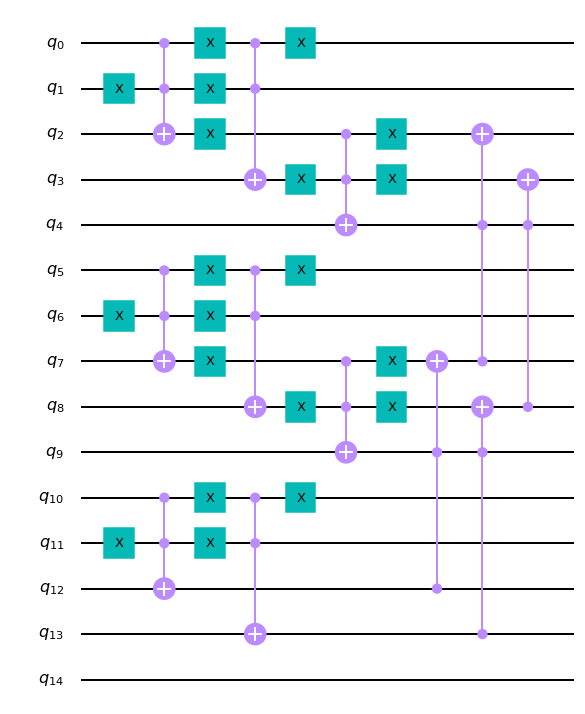

In [169]:
def comparer():   
    comparerCircuit = QuantumCircuit(15)

    for i in range(3) : 
        comparerCircuit.x(5 * i + 1)
        
        comparerCircuit.ccx(5 * i + 0, 5 * i + 1, 5 * i + 2)

        comparerCircuit.x(5 * i + 0)
        comparerCircuit.x(5 * i + 1)
            
        comparerCircuit.ccx(5 * i + 0, 5 * i + 1, 5 * i + 3)

        comparerCircuit.x(5 * i + 0)

    for i in range(2) :
        comparerCircuit.x(5 * i + 2)
        comparerCircuit.x(5 * i + 3)
        
        comparerCircuit.ccx(5 * i + 2, 5 * i + 3, 5 * i + 4)
        
        comparerCircuit.x(5 * i + 2)
        comparerCircuit.x(5 * i + 3)

    comparerCircuit.ccx(12,9,7)
    comparerCircuit.ccx(13,9,8)

    comparerCircuit.ccx(7,4,2)
    comparerCircuit.ccx(8,4,3)
    return comparerCircuit

comparer().draw()

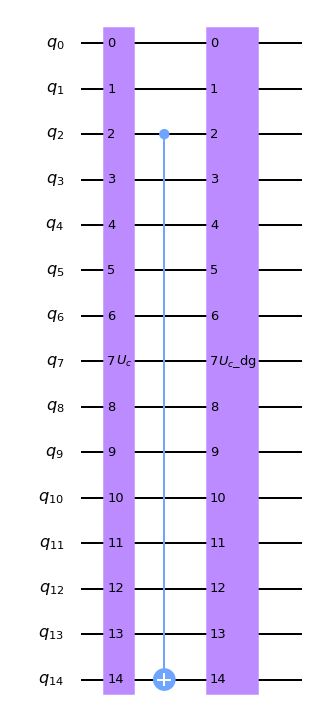

In [170]:
def oracle2():
    qc = QuantumCircuit(15)
    
    U_c = comparer().to_gate()
    U_c.name = "$U_c$"
    
    qc.append(U_c, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

    qc.cx(2, 14)

    qc.append(U_c.inverse(), [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    
    return qc


cbits = ClassicalRegister(3, name='cbits')
grover = QuantumCircuit(15)
grover.add_register(cbits)

oraculus = oracle2()
oraculus.draw()

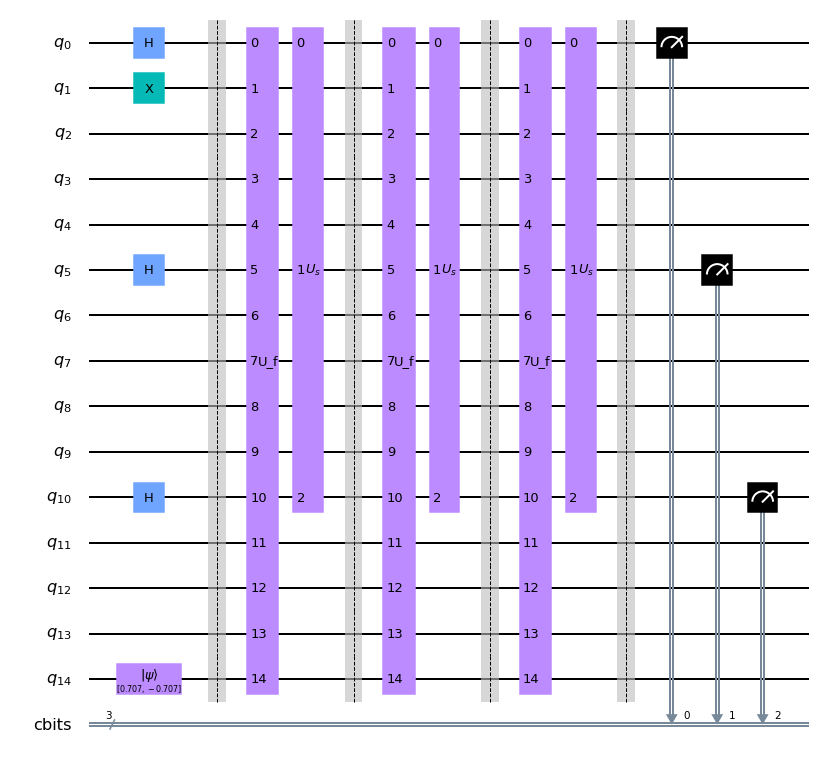

In [171]:
threshold = "100"

if threshold[0] == "1":
    grover.x(1)
if threshold[1] == "1":
    grover.x(6)
if threshold[2] == "1":
    grover.x(11)

grover.initialize([1, -1]/np.sqrt(2), 14)
grover.h([0,5,10])

grover.barrier()

oraculus_gate = oraculus.to_gate()
oraculus_gate.name = "U_f"

iteration = 3
for i in range(iteration) :
    grover.append(oraculus_gate, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    grover.append(diffuser(3), [0,5,10])
    grover.barrier()


grover.measure([0,5,10], cbits)

grover.draw()

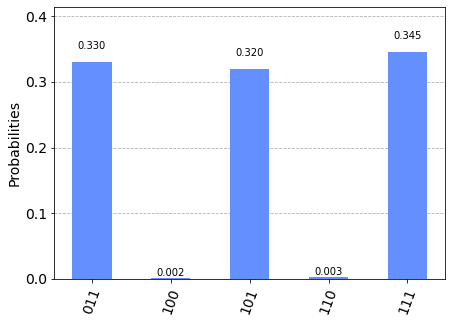

In [172]:
qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [173]:

#Old stuff

def oracle():
    qc = QuantumCircuit(15)

    for i in range(3) : 
        qc.x(5 * i + 1)
        
        qc.ccx(5 * i + 0, 5 * i + 1, 5 * i + 2)

        qc.x(5 * i + 0)
        qc.x(5 * i + 1)
            
        qc.ccx(5 * i + 0, 5 * i + 1, 5 * i + 3)

        qc.x(5 * i + 0)
    
    qc.barrier()

    for i in range(2) :
        qc.x(5 * i + 2)
        qc.x(5 * i + 3)
        
        qc.ccx(5 * i + 2, 5 * i + 3, 5 * i + 4)
        
        qc.x(5 * i + 2)
        qc.x(5 * i + 3)

    qc.ccx(12,9,7)
    qc.ccx(13,9,8)

    qc.ccx(7,4,2)
    qc.ccx(8,4,3)

    qc.cx(2, 14)

    #Uncompute
    qc.barrier()

    qc.ccx(8,4,3)
    qc.ccx(7,4,2)
    qc.ccx(13,9,8)
    qc.ccx(12,9,7)

    qc.barrier()

    for i in range(2) :
        qc.x(5 * i + 2)
        qc.x(5 * i + 3)
        
        qc.ccx(5 * i + 2, 5 * i + 3, 5 * i + 4)
        
        qc.x(5 * i + 2)
        qc.x(5 * i + 3)

    qc.barrier()

    for i in range(3) : 
        qc.x(5 * i + 0)
        
        qc.ccx(5 * i + 0, 5 * i + 1, 5 * i + 3)

        qc.x(5 * i + 1)
        qc.x(5 * i + 0)
        
        qc.ccx(5 * i + 0, 5 * i + 1, 5 * i + 2)    
        
        qc.x(5 * i + 1)
    return qc